In [1]:
%pip install imbalanced-learn

   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/258.0 kB 330.3 kB/s eta 0:00:01
   --------- ----------------------------- 61.4/258.0 kB 544.7 kB/s eta 0:00:01
   ---------------------------------------  256.0/258.0 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 258.0/258.0 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [3]:
# Load the dataset
data = pd.read_csv('..\Dataset\Aggregated_Sleep.csv')

# Removing unnecessary columns
data_cleaned = data.drop(['patient_id', 'window_start'], axis=1)

# Handle missing values by imputing with median
imputer = SimpleImputer(strategy='median')
data_cleaned[data_cleaned.columns] = imputer.fit_transform(data_cleaned)

# Split data into features and target
X = data_cleaned.drop('agitation', axis=1)
y = data_cleaned['agitation']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the data
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# One-class SVM model trained on SMOTE data
svm_model_smote = OneClassSVM(kernel='rbf', gamma='auto').fit(X_train_smote_scaled)

# Isolation Forest model trained on SMOTE data
iso_forest_model_smote = IsolationForest(n_estimators=100, contamination='auto', random_state=42).fit(X_train_smote_scaled)

# Making predictions with SMOTE-trained models
svm_preds_smote = svm_model_smote.predict(X_test_scaled)
iso_forest_preds_smote = iso_forest_model_smote.predict(X_test_scaled)

# Convert predictions from -1, 1 to 0, 1
svm_preds_smote = (svm_preds_smote == -1).astype(int)
iso_forest_preds_smote = (iso_forest_preds_smote == -1).astype(int)

# Evaluate models trained with SMOTE
print("Evaluation with SMOTE:")
print("One-class SVM Report:\n", classification_report(y_test, svm_preds_smote))
print("ROC-AUC for SVM:", roc_auc_score(y_test, svm_preds_smote))
print("Isolation Forest Report:\n", classification_report(y_test, iso_forest_preds_smote))
print("ROC-AUC for Isolation Forest:", roc_auc_score(y_test, iso_forest_preds_smote))

Evaluation with SMOTE:
One-class SVM Report:
               precision    recall  f1-score   support

         0.0       0.96      0.27      0.42       271
         1.0       0.02      0.57      0.04         7

    accuracy                           0.28       278
   macro avg       0.49      0.42      0.23       278
weighted avg       0.94      0.28      0.41       278

ROC-AUC for SVM: 0.42040063257775434
Isolation Forest Report:
               precision    recall  f1-score   support

         0.0       0.97      0.85      0.91       271
         1.0       0.02      0.14      0.04         7

    accuracy                           0.83       278
   macro avg       0.50      0.49      0.47       278
weighted avg       0.95      0.83      0.88       278

ROC-AUC for Isolation Forest: 0.4939377965208223


In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score

# Load the dataset
data = pd.read_csv('..\Dataset\Aggregated_Sleep.csv')
data = data.drop(['patient_id', 'window_start'], axis=1)

# Splitting the data based on the 'agitation' column
positive_data = data[data['agitation'] == 1]
negative_data = data[data['agitation'] == 0]

# Splitting positive data for training (taking all but 2 for testing)
train_pos = positive_data[:-2]  # Taking all but 2 for testing
test_pos = positive_data[-2:]  # Last 2 for testing

# Splitting negative data, random selection for the test set
train_neg, test_neg = train_test_split(negative_data, test_size=0.3, random_state=42)

# Manually oversampling positive samples in the training set by 2x
train_pos_oversampled = pd.concat([train_pos] * 2, ignore_index=True)

# Matching the number of oversampled positive samples with negative samples
train_neg_matched = train_neg.sample(n=len(train_pos_oversampled), random_state=42)

# Combining the matched training sets
X_train = pd.concat([train_pos_oversampled, train_neg_matched])
y_train = X_train['agitation']
X_train = X_train.drop('agitation', axis=1)

# Preparing the test set (20-30 negative cases randomly selected)
test_neg_selected = test_neg.sample(n=25, random_state=42)  # Adjust n for desired test size
X_test = pd.concat([test_pos, test_neg_selected])
y_test = X_test['agitation']
X_test = X_test.drop('agitation', axis=1)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-class SVM model
svm_model = OneClassSVM(kernel='rbf', gamma='auto').fit(X_train_scaled)
svm_preds = svm_model.predict(X_test_scaled)
svm_preds = (svm_preds == -1).astype(int)  # Convert predictions from -1, 1 to 0, 1

# Isolation Forest model
iso_forest_model = IsolationForest(n_estimators=100, contamination='auto', random_state=42).fit(X_train_scaled)
iso_forest_preds = iso_forest_model.predict(X_test_scaled)
iso_forest_preds = (iso_forest_preds == -1).astype(int)  # Convert predictions from -1, 1 to 0, 1

# Evaluation metrics
print("Evaluation Metrics:")
print("One-class SVM Report:\n", classification_report(y_test, svm_preds))
print("ROC-AUC for SVM:", roc_auc_score(y_test, svm_preds))
print("Isolation Forest Report:\n", classification_report(y_test, iso_forest_preds))
print("ROC-AUC for Isolation Forest:", roc_auc_score(y_test, iso_forest_preds))

Evaluation Metrics:
One-class SVM Report:
               precision    recall  f1-score   support

         0.0       0.93      0.52      0.67        25
         1.0       0.08      0.50      0.13         2

    accuracy                           0.52        27
   macro avg       0.50      0.51      0.40        27
weighted avg       0.87      0.52      0.63        27

ROC-AUC for SVM: 0.51
Isolation Forest Report:
               precision    recall  f1-score   support

         0.0       0.91      0.84      0.87        25
         1.0       0.00      0.00      0.00         2

    accuracy                           0.78        27
   macro avg       0.46      0.42      0.44        27
weighted avg       0.85      0.78      0.81        27

ROC-AUC for Isolation Forest: 0.42


In [2]:
data.head()

,patient_id,window_start,mean_HR,HR_var,mean_RR,RR_var,WASO,SOL,TIB,TST,SE,snoring_counts,agitation
0,0f352,2019-06-25 18:00:00,65.039514,3.345222,11.917933,1.348875,270.0,10.0,540.0,204.0,37.777778,0.0,0.0
1,0f352,2019-06-26 18:00:00,67.176030,2.739798,11.456929,0.992935,124.0,19.0,349.0,179.0,51.289398,0.0,0.0
2,0f352,2019-06-27 18:00:00,64.623583,3.076862,11.977324,1.061488,222.0,15.0,569.0,238.0,41.827768,0.0,0.0
3,0f352,2019-06-28 18:00:00,62.416667,4.372302,11.397849,1.110011,61.0,13.0,401.0,309.0,77.057357,80.0,0.0
4,0f352,2019-06-29 12:00:00,68.082569,2.632167,13.330275,1.171064,77.0,12.0,149.0,49.0,32.885906,0.0,0.0


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Load the dataset and drop unnecessary columns
data = pd.read_csv('..\Dataset\Aggregated_Sleep.csv')
data = data.drop(['patient_id', 'window_start'], axis=1)

# Splitting the data based on the 'agitation' column
positive_data = data[data['agitation'] == 1]
negative_data = data[data['agitation'] == 0]

# Splitting positive data for training (taking all but 2 for testing)
train_pos = positive_data[:-2]  # Taking all but 2 for testing
test_pos = positive_data[-2:]  # Last 2 for testing

# Splitting negative data, random selection for the test set
train_neg, test_neg = train_test_split(negative_data, test_size=0.3, random_state=42)

# Manually oversampling positive samples in the training set by 2x
train_pos_oversampled = pd.concat([train_pos] * 2, ignore_index=True)

# Matching the number of oversampled positive samples with negative samples
train_neg_matched = train_neg.sample(n=len(train_pos_oversampled), random_state=42)

# Combining the matched training sets
X_train = pd.concat([train_pos_oversampled, train_neg_matched])
y_train = X_train['agitation']
X_train = X_train.drop('agitation', axis=1)

# Preparing the test set (25 negative cases randomly selected)
test_neg_selected = test_neg.sample(n=25, random_state=42)  # Adjust n for desired test size
X_test = pd.concat([test_pos, test_neg_selected])
y_test = X_test['agitation']
X_test = X_test.drop('agitation', axis=1)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-class SVM model with optimized parameters
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05).fit(X_train_scaled)
svm_scores = svm_model.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, svm_scores, pos_label=1)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
svm_preds = (svm_scores > optimal_threshold).astype(int)

# Isolation Forest model with adjusted parameters
iso_forest_model = IsolationForest(n_estimators=200, contamination=float(np.count_nonzero(y_train==1)/len(y_train)), random_state=42).fit(X_train_scaled)
iso_forest_scores = iso_forest_model.decision_function(X_test_scaled)
iso_forest_preds = (iso_forest_scores < -0.5).astype(int)  # Adjust threshold for better sensitivity

# Evaluation metrics
print("Evaluation Metrics:")
print("One-class SVM Report:\n", classification_report(y_test, svm_preds))
print("ROC-AUC for SVM:", roc_auc_score(y_test, svm_preds))
print("Isolation Forest Report:\n", classification_report(y_test, iso_forest_preds))
print("ROC-AUC for Isolation Forest:", roc_auc_score(y_test, iso_forest_preds))

Evaluation Metrics:
One-class SVM Report:
               precision    recall  f1-score   support

         0.0       0.93      0.56      0.70        25
         1.0       0.08      0.50      0.14         2

    accuracy                           0.56        27
   macro avg       0.51      0.53      0.42        27
weighted avg       0.87      0.56      0.66        27

ROC-AUC for SVM: 0.53
Isolation Forest Report:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        25
         1.0       0.00      0.00      0.00         2

    accuracy                           0.93        27
   macro avg       0.46      0.50      0.48        27
weighted avg       0.86      0.93      0.89        27

ROC-AUC for Isolation Forest: 0.5


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: U

In [5]:
%pip install torch

   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.3/198.6 MB 5.3 MB/s eta 0:00:38
   ---------------------------------------- 0.6/198.6 MB 7.6 MB/s eta 0:00:27
   ---------------------------------------- 1.1/198.6 MB 7.7 MB/s eta 0:00:26
   ---------------------------------------- 1.7/198.6 MB 9.8 MB/s eta 0:00:21
   ---------------------------------------- 2.4/198.6 MB 10.1 MB/s eta 0:00:20
    --------------------------------------- 3.2/198.6 MB 11.9 MB/s eta 0:00:17
    --------------------------------------- 3.8/198.6 MB 12.2 MB/s eta 0:00:16
    --------------------------------------- 4.5/198.6 MB 12.6 MB/s eta 0:00:16
   - -------------------------------------- 5.3/198.6 MB 13.1 MB/s eta 0:00:15
   - -------------------------------------- 5.8/198.6 MB 12.8 MB/s eta 0:00:16
   - -------------------------------------- 6.3/198.6 MB 12.5 MB/s eta 0:00:16
   - -------------------------------------- 6.8/198.6 MB 12.4 MB

# Autoencoder

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('../Dataset/Aggregated_Sleep.csv')
data = data.drop(['patient_id', 'window_start'], axis=1)
X = data.drop('agitation', axis=1).values
y = data['agitation'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_normal = X_train[y_train == 0]  # Only normal data for training

# Convert to PyTorch tensors
X_train_normal_t = torch.tensor(X_train_normal).float()
X_test_t = torch.tensor(X_test).float()
y_test_t = torch.tensor(y_test).float()

# Create DataLoader for batch processing
train_loader = DataLoader(TensorDataset(X_train_normal_t, X_train_normal_t), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, X_test_t), batch_size=256, shuffle=False)

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X_train_normal.shape[1], 14),
            nn.ReLU(),
            nn.Linear(14, 7),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.ReLU(),
            nn.Linear(14, X_train_normal.shape[1]),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
def train(model, train_loader):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Train model
for epoch in range(50):
    train(model, train_loader)

def evaluate(model, test_loader, threshold):
    model.eval()
    predictions = []
    reconstruction_errors = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            output = model(data)
            recon_error = torch.mean((data - output) ** 2, dim=1)  # Mean squared error per sample
            reconstruction_errors.append(recon_error)
            preds = (recon_error > threshold).float()  # Classify as anomaly if error exceeds threshold
            predictions.extend(preds)

    return predictions, reconstruction_errors

# Determine a threshold from training set, e.g., using percentile
train_recon_errors = []
with torch.no_grad():
    for data, _ in train_loader:
        output = model(data)
        train_recon_errors.extend(torch.mean((data - output) ** 2, dim=1).numpy())
threshold = np.percentile(train_recon_errors, 95)  # Setting threshold at 95th percentile

# Evaluate the model
predictions, test_recon_errors = evaluate(model, test_loader, threshold)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Total Predictions: 186, Anomalies Detected: 0.0, Percentage Detected: 0.0%
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       178
         1.0       0.00      0.00      0.00         8

    accuracy                           0.96       186
   macro avg       0.48      0.50      0.49       186
weighted avg       0.92      0.96      0.94       186



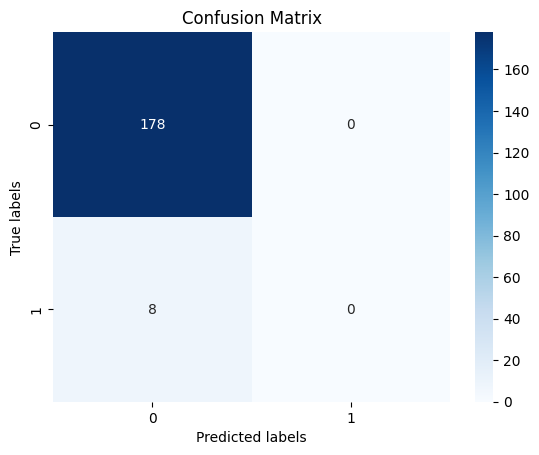

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x600 with 0 Axes>

In [8]:
# Summary statistics
total_predictions = len(predictions)
num_anomalies_detected = np.sum(predictions)
percentage_anomalies_detected = num_anomalies_detected / total_predictions * 100
print(f"Total Predictions: {total_predictions}, Anomalies Detected: {num_anomalies_detected}, Percentage Detected: {percentage_anomalies_detected}%")

# Classification report
print(classification_report(y_test_t.numpy(), predictions, zero_division=0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_t.numpy(), predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(test_recon_errors[y_test_t.numpy() == 0], bins=50, alpha=0.7, label='Normal')
plt.hist(test_recon_errors[y_test_t.numpy() == 1], bins=50, alpha=0.7, label='Anomaly')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Reconstruction Errors')
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_t.numpy(), test_recon_errors)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Autoencoder + One Class SVM Ensemble Model

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np

# Load and preprocess the data
data = pd.read_csv('../Dataset/Aggregated_Sleep.csv')
data = data.drop(['patient_id', 'window_start'], axis=1)

# Drop rows with NaNs
data = data.dropna()

X = data.drop('agitation', axis=1).values
y = data['agitation'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data, focusing only on normal data for training the Autoencoder
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y == 0, test_size=0.2, random_state=42)
X_train_normal = X_train[y_train]

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_features, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, n_features),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training the Autoencoder
autoencoder = Autoencoder(X_train_normal.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_normal).float()), batch_size=32, shuffle=True)

def train_autoencoder(model, loader, epochs=50):
    model.train()
    for epoch in range(epochs):
        for data in loader:
            data = data[0]  # unpack data
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

train_autoencoder(autoencoder, train_loader)

# Extract features for training and testing
autoencoder.eval()
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(torch.tensor(X_train).float()).numpy()
    X_test_encoded = autoencoder.encoder(torch.tensor(X_test).float()).numpy()

# Train One-Class SVM on the encoded features
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
oc_svm.fit(X_train_encoded[y_train])  # Train only on normal data

# Predictions and Evaluation
from sklearn.metrics import classification_report

y_pred_train = oc_svm.predict(X_train_encoded)
y_pred_test = oc_svm.predict(X_test_encoded)
y_pred_test = np.where(y_pred_test == 1, 0, 1)  # Converting from SVM labels to anomaly labels

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

Epoch 1/50, Loss: 1.1442
Epoch 11/50, Loss: 0.5622
Epoch 21/50, Loss: 0.4725
Epoch 31/50, Loss: 0.8408
Epoch 41/50, Loss: 0.7065
Classification Report (Test Set):
              precision    recall  f1-score   support

       False       0.04      1.00      0.08         7
        True       1.00      0.15      0.25       178

    accuracy                           0.18       185
   macro avg       0.52      0.57      0.17       185
weighted avg       0.96      0.18      0.25       185

